# Exercises Hand-In 3 e1
## Group 30 (Oliver Nilsson)

In [1]:
# Import required libraries
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import nltk
from nltk.stem.snowball import SnowballStemmer
import re

# Print the versions of the libraries to check if they are installed correctly
print(f"Pandas version: {pd.__version__}")
print(f"Sklearn version: {sklearn.__version__}")
print(f"NLTK version: {nltk.__version__}")
print(f"Re version: {re.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Pandas version: 1.5.3
Sklearn version: 1.4.2
NLTK version: 3.8.1
Re version: 2.2.1
Matplotlib version: 3.8.4


In [2]:
# Import csv file to a pandas dataframe
df_tweets = pd.read_csv('data/1377884570_tweet_global_warming.csv', encoding='ISO-8859-1', engine='python')
df_tweets.dropna(inplace=True)  # Drop rows with missing values

# Replace Yes/Y with 1 and No/N with 0
df_tweets['existence'] = df_tweets['existence'].map({'Y': 1, 'Yes': 1, 'N': 0, 'No': 0}).astype(int)

# Remove "[link]" from the tweets
df_tweets['tweet'] = df_tweets['tweet'].replace('\\[link\\]', '', regex=True)

# Display the first 5 rows of the dataframe
df_tweets.head()

,tweet,existence,existence.confidence
0,Global warming report urges governments to act...,1,1.0000
1,Fighting poverty and global warming in Africa,1,1.0000
2,Carbon offsets: How a Vatican forest failed to...,1,0.8786
3,Carbon offsets: How a Vatican forest failed to...,1,1.0000
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,1,0.8087


In [3]:
# Split the data randomly into a test and a training set (70/30 % of the observations)
# Using random_state as seed for reproducibility
train_df, test_df = train_test_split(df_tweets, test_size=0.3, random_state=42)

train_df.head()

,tweet,existence,existence.confidence
230,Ocean Saltiness Shows Global Warming Is Intens...,1,1.0000
498,RT @panteraonca07: Slideshow of Alaska Before ...,1,1.0000
2510,"@prismsinc Worlds Greenest Celebrity: Limos, P...",1,0.6499
5115,FRIDAY AFTERNOON IGNORANCE-OFF: Virginia GOP (...,1,0.6717
3370,RT @mmfa: Brain Freeze: Conservative media sti...,1,0.6969


## 1. Train a logistic lasso model to predict non-climate sceptic language

In [4]:
# Define required functions
def alpha_only(text):
    # Only keep alphabetic characters and spaces
    return re.sub("[^a-zA-Z\s]", "", text)

# Create a stemmer object
stemmer = SnowballStemmer("english")

def stem_tokens(tokens):
    # Stem the tokens using the Snowball stemmer
    return [stemmer.stem(token) for token in tokens]

def tokenize(text):
    # Tokenize the text and stem the tokens
    tokens = text.split()
    return stem_tokens(tokens)

# Create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(preprocessor=alpha_only, tokenizer=tokenize, stop_words='english')

# Convert the training and test set to a matrix of TF-IDF features
# Fit and transform the training set
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['tweet'])
# Transform is used to ensure that the test set is transformed using the same vectorizer as the training set
X_test_tfidf = tfidf_vectorizer.transform(test_df['tweet'])

/opt/anaconda3/envs/islp/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/islp/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv'

In [5]:
# Inspect the feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Print the first 5 feature names
print(feature_names)

['aap' 'aaronmorri' 'ab' ... 'ztf' 'zuniaorg' 'zyenab']


This code trains a logistic regression model with cross-validation. It uses Lasso (L1) regularization, which helps in feature selection by penalizing the coefficients. The model is trained using a set of hyperparameters (Cs=2, cv=10) and a specific solver called 'liblinear'. The 'random_state' parameter ensures reproducibility, while 'max_iter' determines the maximum number of iterations for optimization. Finally, the model is fitted using training data transformed using TF-IDF vectorization.

In [6]:
# Logistic Regression with Cross-Validation for Lasso (L1) Regularization
# Create a LogisticRegressionCV object
logistic_l1 = LogisticRegressionCV(Cs=2, cv=10, penalty='l1', solver='liblinear', random_state=42, max_iter=100)
logistic_l1.fit(X_train_tfidf, train_df['existence'])

LogisticRegressionCV(Cs=2, cv=10, penalty='l1', random_state=42,
                     solver='liblinear')

In [7]:
# Display the coefficients of the model
lasso_coef = pd.Series(logistic_l1.coef_[0], index=feature_names)
print(lasso_coef[lasso_coef != 0])

aaronmorri     4.626203
abat         -15.644215
abc           13.695760
abl            0.011088
abnorm         7.204301
                ...    
zealot         2.952347
zener          7.751056
zoeart        -3.266355
zoecaron       0.101842
zyenab        -5.698737
Length: 2002, dtype: float64


In [8]:
# Predict on test data
lasso_pred = logistic_l1.predict_proba(X_test_tfidf)[:, 1]

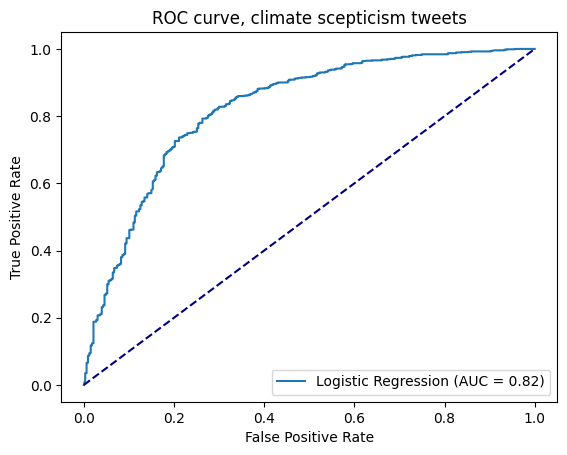

In [9]:
# ROC curve
fpr, tpr, thresholds = roc_curve(test_df['existence'], lasso_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc_score(test_df['existence'], lasso_pred))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, climate scepticism tweets')
plt.legend(loc="lower right")
plt.show()

In [10]:
# Compute AUC
auc = roc_auc_score(test_df['existence'], lasso_pred)
print(f"AUC: {auc}")

AUC: 0.8247878663793805


The AUC (Area Under the Curve) of 0.82 means the model is pretty good at telling apart positive and negative cases. Simply put, there's an 82% chance the model will get it right when deciding if something is positive or negative.

For further testing, we'll check three different tweets. We're using a cutoff value of 0.50 because it's a balanced point. This means the model has an equal chance of getting positive and negative cases right. It's difficult to find a clear break-point where the ROC-curve flattens out in this case.

In [32]:
def predict_climate_scepticism_tfidf(tweet, cutoff=0.5):
    # Transform the tweet to a matrix of TF-IDF features
    tweet_tfidf = tfidf_vectorizer.transform([tweet])

    # Predict the existence of climate scepticism in the tweet
    tweet_pred = logistic_l1.predict_proba(tweet_tfidf)[:, 1]

    # Determine the level of climate scepticism in the tweet
    tweet_pred_level = 1 if tweet_pred[0] > cutoff else 0

    # Determine the conclusion of the prediction
    tweet_pred_conclusion = (
        "Tweet is not sceptical about climate change" if tweet_pred_level == 1
        else "Tweet is sceptical about climate change"
    )

    # Prepare the result message
    result_message = f"\nTweet: {tweet}\n"
    result_message += f"Prediction: {tweet_pred[0]:.2f}\n"
    result_message += f"{tweet_pred_conclusion}"

    return result_message

In [34]:
# Test tweets
tweets = ["Climate change is not happening.",
          "Climate change is a hoax. The earth is not warming up. #climatechange #globalwarming #hoax",
          "The earth is warming up. We need to take action now. #climatechange #globalwarming #action",]

# Predict the climate scepticism of the test tweets using the function
for tweet in tweets:
    print(predict_climate_scepticism_tfidf(tweet))


Tweet: Climate change is not happening.
Prediction: 0.02
Tweet is sceptical about climate change

Tweet: Climate change is a hoax. The earth is not warming up. #climatechange #globalwarming #hoax
Prediction: 0.00
Tweet is sceptical about climate change

Tweet: The earth is warming up. We need to take action now. #climatechange #globalwarming #action
Prediction: 1.00
Tweet is not sceptical about climate change


These results show what the model thinks about three different tweets.

1. The first tweet says climate change isn't happening. The model predicts with 2% certainty that it's sceptical about climate change.

2. The second tweet claims climate change is a hoax and the earth isn't warming. The model predicts with 0% certainty that it's sceptical about climate change.

3. The third tweet acknowledges climate change and urges action. The model predicts with 100% certainty that it's not sceptical about climate change.

In simple terms, the model seems to understand the tweets well, accurately distinguishing between those that doubt climate change and those that don't.